<a href="https://colab.research.google.com/github/fabbio00/Image-classification-on-Pascal-VOC/blob/main/Image-classification-on-Pascal-VOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import dependencies

In [ ]:
import keras
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
from PIL import Image
import re
import csv

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Initialize main paths

In [ ]:
# impostare la path in cui si trova il file con il codice
main_path = '/content/drive/MyDrive/Consegna_AML_Andena_Marini'
annot_path = main_path + '/dataset_grande/Annotations/'
images_path = main_path + '/dataset_grande/JPEGImages/'

## Pre-processing of data

In [ ]:
# creazione dataframe con tutti i file name degli xml
xml_files = [file for file in os.listdir(annot_path) if file.endswith('.xml')]
dfXML = pd.DataFrame({'fileName': xml_files})

In [ ]:
csv_path = main_path + '/filesXML.csv'
dfXML.to_csv(csv_path, index=False)

In [ ]:
df = pd.DataFrame(columns=['fileName','xmin','ymin','xmax','ymax','class'])

In [ ]:
allFiles = [f for f in listdir(annot_path) if isfile(join(annot_path, f))]
print(len(allFiles))

17235


In [ ]:
def create_df(data, vector):
  for file in vector:
    if(file.split(".")[1] == 'xml'):
      fileName = file.replace(".xml", ".jpg") # prendo l'immagine jpg associata all'xml
      # inizializzo l'albero xml del file che sto ciclando
      tree = ET.parse(annot_path + file)
      root = tree.getroot()

      # intercetto le informazioni dei tag dell'albero
      for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xml_box = obj.find('bndbox')
        xmin = xml_box.find('xmin').text
        ymin = xml_box.find('ymin').text
        xmax = xml_box.find('xmax').text
        ymax = xml_box.find('ymax').text

        new_row = pd.DataFrame({'fileName': [fileName], 'xmin': [xmin], 'ymin': [ymin], 'xmax': [xmax], 'ymax': [ymax], 'class': [cls_name]})
        data = pd.concat([data, new_row], ignore_index=True)

  return data

In [ ]:
df = create_df(df, allFiles)
df.head()

Save to CSV

In [ ]:
csv_path = main_path + '/annotFiles.csv'
df.to_csv(csv_path, index=False)

### Test of matching bounding boxes to images

Loading CSV

In [ ]:
csv_path = main_path + '/annotFiles.csv'
df = pd.read_csv(csv_path)

In [ ]:
# prendo un'immagine random
filepath = df.sample()['fileName'].values[0]
print(filepath)

# prendo tutte le righe del dataframe che danno informazioni sull'immagine
df2 = df[df['fileName'] == filepath]

# inizializzo l'immagine jpg
im = np.array(Image.open(filepath))

In [ ]:
image = cv2.imread(filepath)

# Creare una copia dell'immagine originale
image_with_rectangles = image.copy()

# Creare rettangoli per ogni coordinata e disegnarli sull'immagine copiata
for idx, row in df2.iterrows():
    print(row['class'])
    box = np.array([
         int(row['xmin']),
         int(row['ymin']),
         int(row['xmax']),
         int(row['ymax'])
    ])
    print(box)
    cv2.rectangle(image_with_rectangles, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)  # (0, 0, 255) rappresenta il colore rosso, 2 è lo spessore della linea

# Visualizza l'immagine con tutti i rettangoli
plt.imshow(cv2.cvtColor(image_with_rectangles, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Creating the background class

In [ ]:
def clean_filename(filename):
    # Utilizza espressioni regolari per cercare eventuali parentesi tonde alla fine del nome del file
    match = re.search(r' \(\d+\)\.', filename)
    # Se trova una corrispondenza, rimuovi la parte tra parentesi tonde
    if match:
      filename = filename[:match.start()] + filename[match.end()-1:]
    return filename

In [ ]:
csv_path = main_path + '/filesXML.csv'
dfFilesXML = pd.read_csv(csv_path)

background_df = pd.DataFrame(columns=['fileName','xmin','ymin','xmax','ymax','class'])

folder_path = main_path + '/background_img'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Cartella '{folder_path}' creata con successo.")
else:
    print(f"La cartella '{folder_path}' esiste già.")

k = 0

for i in range(len(dfFilesXML)):
  print(i)

  annot = dfFilesXML.at[i, "fileName"]
  annot = clean_filename(annot)
  print(annot)

  annotations = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax'])

  if(annot.split(".")[1] == 'xml'):
    fileName = images_path + annot.replace(".xml", ".jpg") # prendo l'immagine jpg associata all'xml
    image = cv2.imread(fileName)
    # inizializzo l'albero xml del file che sto ciclando
    tree = ET.parse(annot_path + annot)
    root = tree.getroot()

    # intercetto le informazioni dei tag dell'albero
    for obj in root.iter('object'):
      cls_name = obj.find('name').text
      xml_box = obj.find('bndbox')
      xmin = xml_box.find('xmin').text
      ymin = xml_box.find('ymin').text
      xmax = xml_box.find('xmax').text
      ymax = xml_box.find('ymax').text

      new_row = pd.DataFrame({'xmin': [xmin], 'ymin': [ymin], 'xmax': [xmax], 'ymax': [ymax]})
      annotations = pd.concat([annotations, new_row], ignore_index=True)

  # Definisco la dimensione della finestra per i ritagli casuali
  window_size = (150, 150)

  num_background_images = 3
  # Creo una lista per contenere le immagini generate
  background_images = []

  for _ in range(num_background_images):
    # Scelgo casualmente le coordinate di inizio della finestra
    if(image.shape[1] - window_size[0] > 0 and image.shape[0] - window_size[1] > 0):
      start_x = np.random.randint(0, image.shape[1] - window_size[0]) # restituisce un numero tra 0 e larghezza dell'immagine - larghezza della finiestra
      start_y = np.random.randint(0, image.shape[0] - window_size[1]) # restituisce un numero tra 0 e altezza dell'immagine - altezza della finiestra

    # Controllo se la finestra si sovrappone con qualche bounding box
    overlapping = False
    for index, row in annotations.iterrows():
      if (
          start_x < int(row.xmax) and
          start_x + window_size[0] > int(row.xmin) and
          start_y < int(row.ymax) and
          start_y + window_size[1] > int(row.ymin)
      ):
          overlapping = True
          break

    # Se la finestra non si sovrappone, ritaglia e aggiungi all'elenco
    if not overlapping:
      k += 1
      window = image[start_y:start_y + window_size[1], start_x:start_x + window_size[0]]
      if not window.size == 0: # verifico che l'immagine sia stata caricacata correttamente prima di convertire i colori
        save_path = main_path + f'/background_img/background_image{k}.jpg'
        print(save_path)
        cv2.imwrite(save_path, cv2.cvtColor(window, cv2.COLOR_RGB2BGR))

        new_row = pd.DataFrame({'fileName': [save_path], 'xmin': [start_x], 'ymin': [start_y],
                                'xmax': [start_x + window_size[0]], 'ymax': [start_y + window_size[1]], 'class': ["background"]})
        background_df = pd.concat([background_df, new_row], ignore_index=True)

In [ ]:
csv_path = main_path + '/annotBackground.csv'
background_df.to_csv(csv_path, index=False)

## Cutting and saving bounding boxes from images

In [ ]:
csv_path = main_path + '/annotFiles.csv'
annotations = pd.read_csv(csv_path)
print(len(annotations))

# creo la cartella dove salvare le immagini
folder_path = main_path + '/dataset_grande/CuttedBoundingBoxesImages/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Cartella '{folder_path}' creata con successo.")
else:
    print(f"La cartella '{folder_path}' esiste già.")

In [ ]:
for i in range(0, len(annotations)):

  newPath = images_path + annotations['fileName'].iloc[i]
  print(newPath)
  ymin = int(annotations['ymin'].iloc[i])
  ymax = int(annotations['ymax'].iloc[i])
  xmin = int(annotations['xmin'].iloc[i])
  xmax = int(annotations['xmax'].iloc[i])
  img = cv2.imread(newPath)[ymin:ymax, xmin:xmax]

  newName = os.path.splitext(annotations['fileName'].iloc[i])[0] + annotations['class'].iloc[i] + str(i)
  # Salvo l'immagine ritagliata nel percorso specificato
  cv2.imwrite(main_path + '/dataset_grande/CuttedBoundingBoxesImages/' +  newName + '.jpg' , img)
  #Adeguo il nome delle righe nel csv al nuovo nome
  annotations['fileName'].iloc[i] =  newName + 'jpg'

In [ ]:
csv_path = main_path + '/dataset_grande/BoundingBoxes.csv'
annotations.to_csv(csv_path, index=False)

## Creating test set and train set

### Splitting test set and train set

In [ ]:
data = pd.read_csv(main_path + '/dataset_grande/BoundingBoxes.csv')
data_back = pd.read_csv(main_path + '/annotBackground.csv')
data = pd.concat([data, data_back], axis=0, ignore_index=True)

# Contare il numero di samples per ogni classe
class_counts = data['class'].value_counts()

# Inizializzare un DataFrame vuoto per il dataset bilanciato
balanced_test_df = pd.DataFrame()

# Per ogni classe, prendo un numero di campioni fino a raggiungere il limite imposto
for class_label in class_counts.index:
    class_df = data[data['class'] == class_label]
    samples_per_class = min(100, len(class_df))  # Prendo 100 campioni o il numero disponibile se minore di 100
    balanced_samples = class_df.sample(samples_per_class, random_state=42)
    balanced_test_df = pd.concat([balanced_test_df, balanced_samples], axis=0)

In [ ]:
# Estrarre i nomi dei file unici da entrambi i dataset
unique_corrected_file_names = data['fileName'].unique()
unique_modified_dataset_balanced = balanced_test_df['fileName'].unique()

# Calcolare la differenza tra le due liste di nomi di file
difference = set(unique_corrected_file_names) - set(unique_modified_dataset_balanced)

# Filtrare il DataFrame originale per ottenere solo le righe con i nomi dei file nella differenza
difference_df = data[data['fileName'].isin(difference)]

In [ ]:
print(len(balanced_test_df))
print(len(difference_df))

2100
42655


In [ ]:
balanced_test_df.to_csv(main_path + '/dataset_testing.csv', index=False)
difference_df.to_csv(main_path + '/boundingBoxes_senza_testing.csv', index=False)

### Balancing training classes

In [ ]:
train_df =  pd.read_csv(main_path + '/boundingBoxes_senza_testing.csv')
train_df.tail()

,fileName,xmin,ymin,xmax,ymax,class
42650,background_image_4443.jpg,250,129.0,400,279,background
42651,background_image_4444.jpg,201,87.0,351,237,background
42652,background_image_4445.jpg,72,186.0,222,336,background
42653,background_image_4446.jpg,40,5.0,190,155,background
42654,background_image_4447.jpg,148,35.0,298,185,background


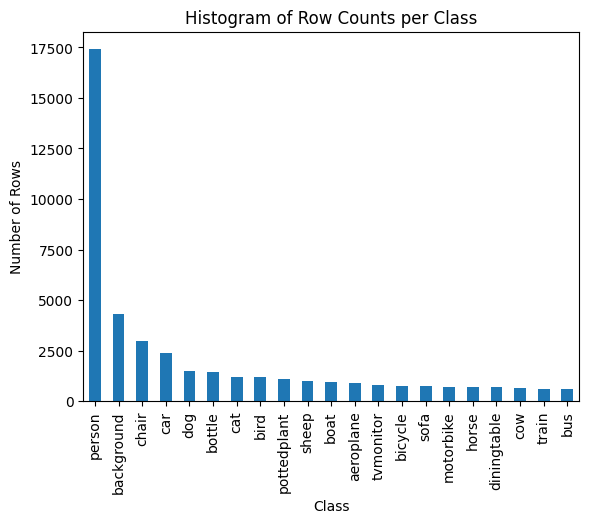

Conteggio delle classi:
person         17407
background      4323
chair           2958
car             2398
dog             1505
bottle          1467
cat             1189
bird            1178
pottedplant     1102
sheep            987
boat             963
aeroplane        909
tvmonitor        795
bicycle          742
sofa             741
motorbike        717
horse            706
diningtable      701
cow              673
train            608
bus              586
Name: class, dtype: int64


In [ ]:
class_counts = train_df['class'].value_counts()

# Visualizzare i dati con un istogramma
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Rows')
plt.title('Histogram of Row Counts per Class')
plt.show()

print("Conteggio delle classi:")
print(class_counts)

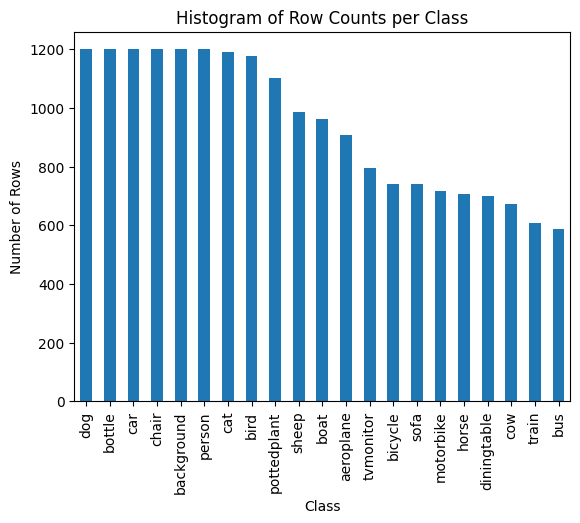

Conteggio delle classi:
dog            1200
bottle         1200
car            1200
chair          1200
background     1200
person         1200
cat            1189
bird           1178
pottedplant    1102
sheep           987
boat            963
aeroplane       909
tvmonitor       795
bicycle         742
sofa            741
motorbike       717
horse           706
diningtable     701
cow             673
train           608
bus             586
Name: class, dtype: int64


In [ ]:
# mischia le righe del dataframe
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Funzione per limitare il numero di righe per classe
def limit_rows(x):
    return x.head(1200)

# Applicare la funzione a ogni gruppo di classi
limited_df = train_df.groupby('class').apply(limit_rows).reset_index(drop=True)

class_counts = limited_df['class'].value_counts()

class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Rows')
plt.title('Histogram of Row Counts per Class')
plt.show()

print("Conteggio delle classi:")
print(class_counts)

In [ ]:
len(limited_df)

19797

In [ ]:
# randomizzare e salvare il dataset
limited_df = train_df.sample(frac=1).reset_index(drop=True)
limited_df.to_csv(main_path + '/dataset_training.csv', index=False)

## Data Augmentation

In [ ]:
csv_file = main_path + '/dataset_grande/BoundingBoxes.csv'
save_dir = main_path + '/dataset_grande/AugmentedImages/'
newdf = pd.DataFrame(columns=['fileName','xmin','ymin','xmax','ymax','class'])

df = pd.read_csv(csv_file)

# Creo la cartella di salvataggio se non esiste
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def crop_and_save_images(class_group, class_name, newdf):
    count = 0
    for _, row in class_group.iterrows():
        if count >= 50:
            break
        image_path = os.path.join(main_path + '/dataset_grande/CuttedBoundingBoxesImages/', row['fileName'])
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        for i in range(3):
            if image.shape[0] < 150 or image.shape[1] < 150:
                break  # Salta l'immagine se troppo piccola
            seed = (i, 0)
            cropped_image = tf.image.stateless_random_crop(image, size=[150, 150, 3], seed=seed)
            fileName = f"{class_name}_{row['fileName'].split('.')[0]}_{i}.jpg"
            save_path = os.path.join(save_dir, fileName)
            new_row = pd.DataFrame({'fileName': [fileName], 'xmin': 0, 'ymin': 0, 'xmax': 150, 'ymax': 150, 'class': [class_name]})
            newdf = pd.concat([newdf, new_row], ignore_index=True)
            tf.io.write_file(save_path, tf.image.encode_jpeg(cropped_image))
            count += 1
    return newdf

# Applico il cropping e il salvataggio per ogni classe e aggiorna il dataframe
for class_name, group in df.groupby('class'):
    newdf = crop_and_save_images(group, class_name, newdf)


newdf.to_csv(main_path + '/AugmentedImages.csv', index=False)

In [ ]:
folder_path = main_path + '/dataset_grande/AugmentedImages'

output_csv = main_path + '/augmImg.csv'

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['fileName', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg'):  # Seleziona solo i file .jpg
            # Estrarre la parte del nome prima del primo '_'
            class_name = file_name.split('_')[0]
            print(class_name)
            writer.writerow([file_name, 0, 0, 0, 0, class_name])

print(f"Dati salvati con successo in {output_csv}")

## Training

### Loading data

In [ ]:
train_df = pd.read_csv(main_path + '/dataset_training.csv')

#Adeguamento indirizzi immagini a drive individuali
for i in range(len(train_df)):
    if train_df.loc[i, 'class'] == 'background':
        train_df.loc[i, 'fileName'] = main_path + '/background_img/' + train_df.loc[i, 'fileName']
    else:
        train_df.loc[i, 'fileName'] = main_path + '/dataset_grande/CuttedBoundingBoxesImages/' + train_df.loc[i, 'fileName']

In [ ]:
batch_size = 128

# Configurazione del generatore di dati
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
)

# Carica il training set
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='fileName',
    y_col='class',
    weight_col=None,
    target_size=(299, 299),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset="training",
    interpolation='nearest',
    validate_filenames=True,
)

# Carica il validation set
validation_generator = datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='fileName',
    y_col='class',
    weight_col=None,
    target_size=(299, 299),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset="validation",
    interpolation='nearest',
    validate_filenames=True,
)

### Loading data with data augmentation

Eseguire questa sezione solo per effettuare il training con data augmentation

In [ ]:
train_df = pd.read_csv(main_path + '/dataset_training.csv')

for i in range(len(train_df)):
    if train_df.loc[i, 'class'] == 'background':
        train_df.loc[i, 'fileName'] = main_path + '/background_img/' + train_df.loc[i, 'fileName']
    else:
        train_df.loc[i, 'fileName'] = main_path + '/dataset_grande/CuttedBoundingBoxesImages/' + train_df.loc[i, 'fileName']


augmented_df = pd.read_csv(main_path + '/augmImg.csv')
for i in range(0, len(augmented_df)):
   augmented_df['fileName'].iloc[i] = main_path  + '/dataset_grande/AugmentedImages/' + augmented_df['fileName'].iloc[i]

In [ ]:
train_df = pd.concat([train_df, augmented_df], axis=0, ignore_index=True)
train_df.tail()

In [ ]:
batch_size = 128

# Filtrare le immagini augmentate
augmented_images = train_df[train_df['fileName'].str.contains('aug')]
non_augmented_images = train_df[~train_df['fileName'].str.contains('aug')]

# Dividere le immagini non augmentate in training e validation set
train_non_aug, validation = train_test_split(non_augmented_images, test_size=0.2, random_state=1)

# Unire le immagini augmentate con il training set non augmentato
train_df_final = pd.concat([augmented_images, train_non_aug])

# Configura il generatore di dati per il training (con data augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
)


validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Generatore di training
train_generator = train_datagen.flow_from_dataframe(
    train_df_final,
    directory=None,
    x_col='fileName',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset=None,
)

# Generatore di validation
validation_generator = validation_datagen.flow_from_dataframe(
    validation,
    directory=None,
    x_col='fileName',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset=None,
)

### Checking data

In [ ]:
#per vedere come sono associate le classi
class_indices_mapping = train_generator.class_indices

# Stampa la mappatura
print("Mappatura tra nomi delle classi e indici numerici:")
for class_name, class_index in class_indices_mapping.items():
    print(f"{class_name}: {class_index}")

In [ ]:
class_labels = train_generator.classes

# Conta le occorrenze di ciascuna classe
from collections import Counter
class_distribution = Counter(class_labels)

# Stampa la distribuzione delle classi
print("Distribuzione delle classi nel train_generator:")
for class_label, count in class_distribution.items():
    print(f"Classe {class_label}: {count} campioni")

### Loading Network

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# taglio del modello
base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed9').output)

In [ ]:
from keras.regularizers import l1_l2, l2, l1
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers. Dense (500, activation='relu'),
    layers.Dropout (0.5),
    layers. Dense (400, activation='relu'),
    layers.Dropout (0.5),
    layers. Dense (300, activation='relu'),
    layers.Dropout (0.5),
    layers. Dense (200, activation='relu'),
    layers.Dropout (0.5),
    layers.Dense(21, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 2048)        15722720  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 500)               1024500   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               200400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                        

In [ ]:
checkpoint_path = main_path + '/checkpoint/modello-{epoch:02d}.h5'

folder_path = main_path + '/checkpoint'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Cartella '{folder_path}' creata con successo.")
else:
    print(f"La cartella '{folder_path}' esiste già.")

# Crea il callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

In [ ]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=validation_generator, callbacks=[checkpoint_callback])

model.save(main_path + '/checkpoint/model.h5')

In [ ]:
def plot_performance(history):
  fig, ax = plt.subplots(1, 2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  valid_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label='Training Loss')
  ax[0].plot(valid_loss, label='Validation Loss')
  ax[0].legend()
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].plot(train_acc, label='Train accuracy')
  ax[1].plot(valid_acc, label='Validation accuracy')
  ax[1].legend()
  plt.show()

plot_performance(history)

## Testing

### Bounded Boxes Prediction

In [ ]:
class_mapping = {
    0: 'aeroplane',
    1: 'background',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'pottedplant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tvmonitor'
}

In [ ]:
test_df =  pd.read_csv(main_path + '/dataset_testing.csv')

for i in range(len(test_df)):
    if test_df.loc[i, 'class'] == 'background':
        test_df.loc[i, 'fileName'] = main_path + '/background_img/' + test_df.loc[i, 'fileName']
    else:
        test_df.loc[i, 'fileName'] = main_path + '/dataset_grande/CuttedBoundingBoxesImages/' + test_df.loc[i, 'fileName']

In [ ]:
model = load_model(main_path + '/checkpoint/model.h5')

class_correct_predictions = defaultdict(int)
class_total_predictions = defaultdict(int)

true_labels = []
predicted_labels = []

total_predictions = 0
correct_predictions = 0

for index, row in test_df.iterrows():
    if(index % 100 == 0):
      print(index)
    file_path = row['fileName']
    if os.path.exists(file_path):
        img = image.load_img(file_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # previsione del modello
        predictions = model.predict(img_array, verbose = 0)
        predicted_indexes = np.argmax(predictions, axis=1)
        predicted_class = [class_mapping[index] for index in predicted_indexes]
        # classe reale
        true_class = row['class']

        # Aggiorna le liste per la matrice di confusione
        true_labels.append(true_class)
        predicted_labels.append(predicted_class[0])

        # Aggiorna i contatori per la classe reale
        class_total_predictions[true_class] += 1

        # Se la previsione è corretta, aggiorna anche il contatore delle corrette
        if predicted_class[0] == true_class:
            class_correct_predictions[true_class] += 1
            correct_predictions += 1
        total_predictions += 1
    else:
        print(f"File not found: {file_path}")

# Calcola l'accuracy per ogni classe
class_accuracies = {class_label: (class_correct_predictions[class_label] / class_total_predictions[class_label] if class_total_predictions[class_label] > 0 else 0)
                    for class_label in class_total_predictions.keys()}

for class_label, accuracy in class_accuracies.items():
    print(f'Accuracy for class {class_label}: {accuracy:.2f}')

# Calcola l'accuracy totale
accuracy_tot = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f'Accuracy: {accuracy_tot}')

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Nomi delle classi in ordine basato sugli indici
class_names = [class_mapping[i] for i in range(len(class_mapping))]

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice di Confusione')
plt.xlabel('Etichette Previste')
plt.ylabel('Etichette Vere')
plt.show()


### Precision, recall, F1

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='fileName',
    y_col='class',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

In [ ]:
class_indices_mapping = test_generator.class_indices

y_test = test_df['class'].values
y_test = [class_indices_mapping[index] for index in y_test]

predictions = model.predict(test_generator, steps=len(test_generator))

In [ ]:
def convert_to_one_hot(number, num_classes):
    one_hot = np.zeros(num_classes)
    one_hot[number] = 1
    return one_hot

one_hot_list = []
for number in y_test:
  one_hot_vector = convert_to_one_hot(number, 21)
  one_hot_list.append(one_hot_vector)

In [ ]:
from sklearn.metrics import classification_report

predicted = (predictions > 0.5).astype(int)

y_true = one_hot_list
y_pred = predicted
target_names = class_indices_mapping.keys()
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

### Sliding Window

In [ ]:
# scale = fattore di ridimensionamento dell'immagine ad ogni interazione
# minSize = non genera immagini al di sotto di questo valore
def pyramid(image, scale=1.5, minSize=(30, 30)):
    pyramid_images = [image]  # primo valore generato che corrisponde all'immagine intera
    while True:
        w = int(image.shape[1] / scale) # calcola la nuova dimensione a partire dalla larghezza dell'immagine
        image = cv2.resize(image, (w, w)) # imposta altezza e larghezza a w in modo che siano uguali
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]: # controlla se la dimensione non ha sforato la minsize
            break
        pyramid_images.append(image)
    return pyramid_images

def sliding_window(image, stepSize, windowSize):
    windows = []
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            windows.append((x, y, image[y:y + windowSize[1], x:x + windowSize[0]]))
    return windows

def preprocess_for_model(window, target_size=(299, 299)):
    window = cv2.resize(window, target_size)
    window = window.astype("float32") / 255.0
    window = np.expand_dims(window, axis=0)
    return window

In [ ]:
model = load_model(main_path + '/checkpoint/model.h5')
image = cv2.imread(main_path + '/dataset_grande/JPEGImages/2007_000039.jpg')

# definisco la dimensione della finestra e il passo
(winW, winH) = (160, 160)
stepSize = 32

detected_classes = set()

confidence_threshold = 0.8

for resized in pyramid(image, scale=1.5):
    for (x, y, window) in sliding_window(resized, stepSize=stepSize, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
        plt.show()

        # Pre-elaborazione e predizione
        window_processed = preprocess_for_model(window)
        preds = model.predict(window_processed)

        # Ottenere l'indice della classe con la massima probabilità
        predicted_class_index = np.argmax(preds, axis=-1)[0]
        # Ottenere il valore di probabilità per la classe predetta
        predicted_class_probability = np.max(preds, axis=-1)[0]

        # Controlla se la predizione supera la soglia di confidenza
        if predicted_class_probability >= confidence_threshold:
            print(f"Classe predetta: {class_mapping[predicted_class_index]} con probabilità: {predicted_class_probability}")

            # evitare duplicati nell'output finale
            if predicted_class_index not in detected_classes:
                detected_classes.add(predicted_class_index)

if(len(detected_classes) == 0 or (len(detected_classes) == 1 and  class_mapping[list(detected_classes[0])] == 'background')):
  print("Nessun oggetto rilevato")
else:
  print("Classi rilevate nell'immagine:")
  for cls in detected_classes:
      print(class_mapping[cls])